In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click to toggle code"></form>''')

In [1]:
!rm -Rf ~/.cache/rootpy pax_*
import os, sys
import numpy as np
from multihist import Histdd, Hist1d
import matplotlib
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'   # enable if you have a retina display
import pandas as pd
from scipy.optimize import curve_fit, minimize
pd.options.mode.chained_assignment = None        # default='warn'
import warnings
warnings.filterwarnings('ignore')

from scipy.interpolate import interp1d
from scipy.special import erf
from scipy.stats import chi2
from numpy import sqrt, exp, pi

def plt_config(title = None, xbounds = None, ybounds = None, xlabel = None, ylabel = None, colorbar = False, sci = False):
    if sci:
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    if title != None: plt.title(title)
    if xbounds != None: plt.xlim(xbounds)
    if ybounds != None: plt.ylim(ybounds)
    if xlabel != None: plt.xlabel(xlabel)
    if ylabel != None:  plt.ylabel(ylabel)
    if isinstance(colorbar,str):
        plt.colorbar(label = colorbar)
    elif colorbar:
        plt.colorbar(label = 'Number of entries')
    else:
        pass

# Make multihist even easier to use
from contextlib import contextmanager
@contextmanager
def plotting2d(coor):
    if isinstance(coor, list):
        ax = fig.add_subplot(*coor)
    else:
        ax = fig.add_subplot(coor)
    yield ax
    global mh
    mh.plot(log_scale = True, cmap=plt.get_cmap('viridis'), alpha = 1.0 )

@contextmanager
def plotting1d(coor):
    if isinstance(coor, list):
        ax = fig.add_subplot(*coor)
    else:
        ax = fig.add_subplot(coor)
    yield ax
    global ph
    ph.plot()


### Prospective S2 Single Scatter Cut

- Tianyu July 5

#### Motivation

- With the knowledge of that __single electrons__ (SE) and __multi-electron-pile-ups__ (pile-up) making up the mojority of the S2 background, here we try to separate a true scatter S2 peak from those backgrounds.

- After the study on quantitatively describing the probability of other largest S2s being just a SE peak or a pile-up and using likelihood ratio test to classify peaks. We realized that pile-ups are what limiting our cut while SEs can be easily identified.

- The reason why pile-ups limit our capability to improve the cut is that they are exactly the same as low energy true scatters in area, width, time_delay_from_main_s1 space, which unfortunately our likelihood ratio test was built on.

##### Introduction

- The the main goal here is still to tell single electron and pile-up from a true scatter. The figures shown below depict those cases, as a true scatter would be larger, and have an expected width from diffusion model, while single electron and pile-up would have other features.

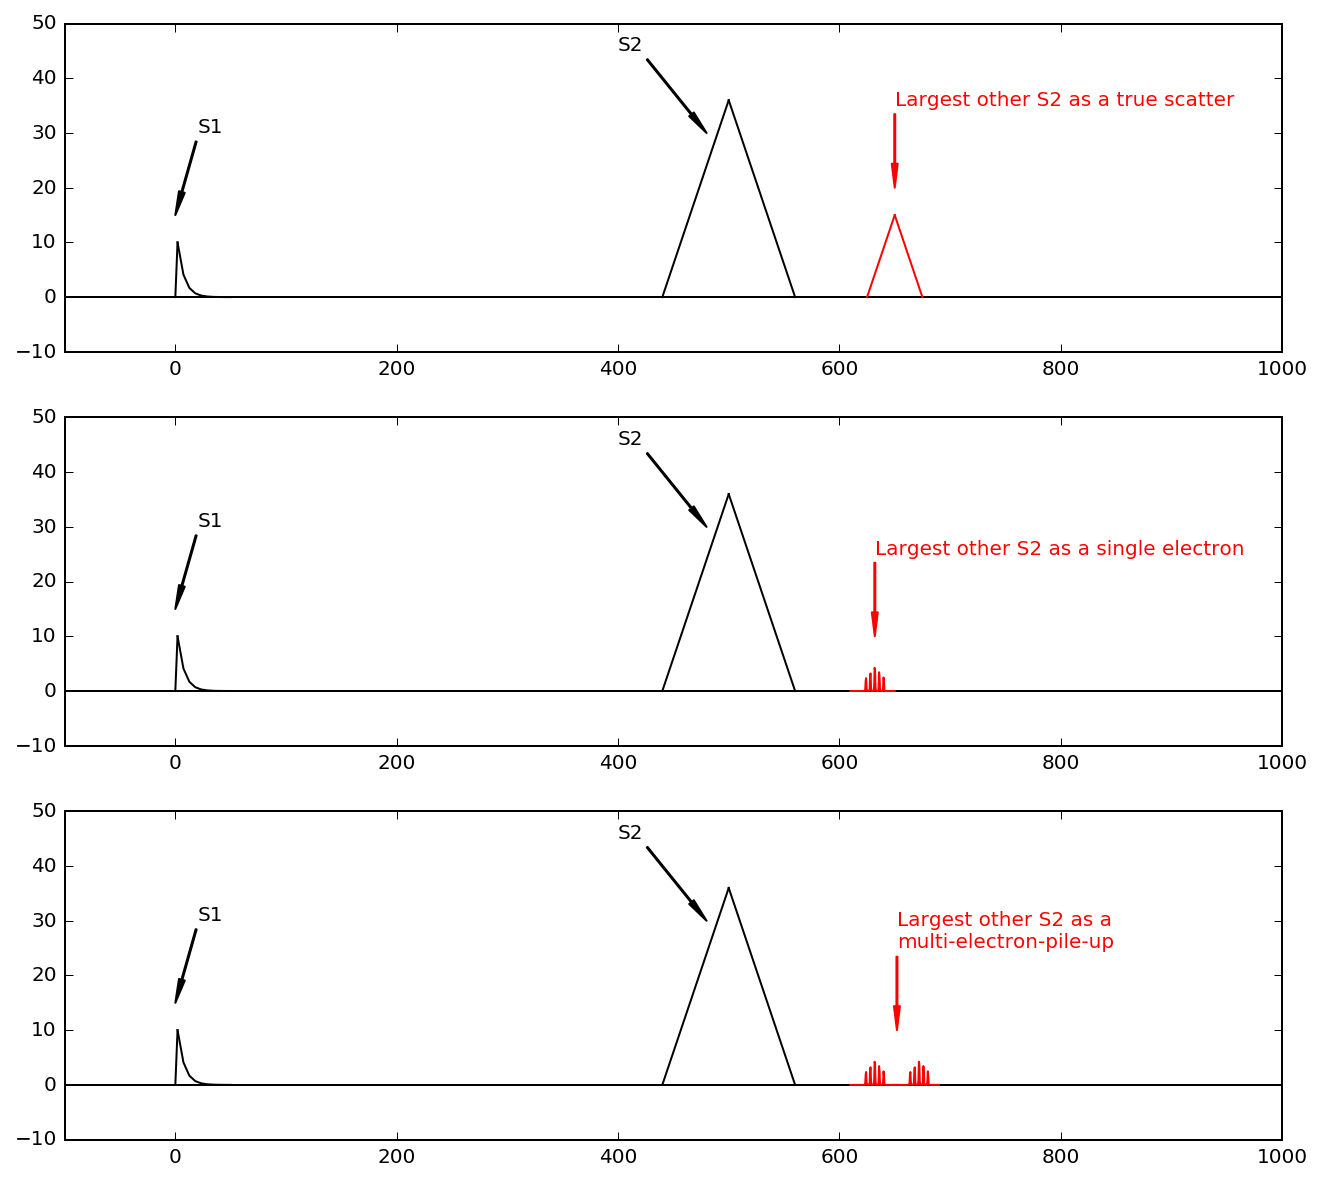

In [290]:
# Make some figures for demo
plt.rcParams['figure.figsize'] = (24, 10)
plt.rcParams['font.size'] = 10
fig = plt.figure()

def plot_s1(time):
    x = np.linspace(time,time+2,10)
    plt.plot(x, 5*(x-time), 'k-')
    x = np.linspace(time+2,time+50,10)
    plt.plot(x, 10*np.exp(-(x-time-2)/6),'k-')
    
def plot_s2(time,h = 36, c = 'k'):
    x = np.linspace(time-h/0.6,time,10)
    plt.plot(x,h+0.6*(x-time),'-',color = c)
    x = np.linspace(time,time+h/0.6,10)
    plt.plot(x,h-0.6*(x-time),'-',color = c)
    
def plot_se(time,c = 'r'):
    x = np.linspace(time-10,time+30,100)   
    def g(x,mu,a):
        return np.exp(-(x-mu)**2/0.2)*a
    y=0
    for mu in time + np.asarray([1,2,3,4,5])*4:
        y+=g(x,mu,5-abs(mu-time-12)*0.3)
        
    plt.plot(x,y,'-',color = c)

ax = fig.add_subplot(321)
plt.axhline(0,color = 'k',ls = '-')
plt_config(xbounds = [-100,1e3], ybounds = [-10,50])
plot_s1(0)
plot_s2(500)
plot_s2(650,h = 15,c = 'r')
ax.annotate('S1', xy=(0, 15), xytext=(20, 30),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('S2', xy=(480, 30), xytext=(400, 45),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('Largest other S2 as a true scatter', xy=(650, 20), xytext=(650, 35), color = 'r',
            arrowprops=dict(facecolor='red', width = 0.5,headwidth = 3.0,color = 'r'))



ax = fig.add_subplot(323)
plt.axhline(0,color = 'k',ls = '-')
plt_config(xbounds = [-100,1e3], ybounds = [-10,50])
plot_s1(0)
plot_s2(500)
plot_se(620)
ax.annotate('S1', xy=(0, 15), xytext=(20, 30),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('S2', xy=(480, 30), xytext=(400, 45),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('Largest other S2 as a single electron', xy=(632, 10), xytext=(632, 25), color = 'r',
            arrowprops=dict(facecolor='red', width = 0.5,headwidth = 3.0,color = 'r'))



ax = fig.add_subplot(325)
plt.axhline(0,color = 'k',ls = '-')
plt_config(xbounds = [-100,1e3], ybounds = [-10,50])
plot_s1(0)
plot_s2(500)
plot_se(620)

plot_se(660)
ax.annotate('S1', xy=(0, 15), xytext=(20, 30),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('S2', xy=(480, 30), xytext=(400, 45),
            arrowprops=dict(facecolor='black', width = 0.5,headwidth = 3.0))
ax.annotate('Largest other S2 as a \nmulti-electron-pile-up', xy=(652, 10), xytext=(652, 25), color = 'r',
            arrowprops=dict(facecolor='red', width = 0.5,headwidth = 3.0,color = 'r'))

plt.show()

- Apart from using area and width of the largest_other_s2 peak we explicitly explore other parameters (goodness of top pattern fit, time delay from main S2) that could effectively tell pile-ups from true scatters. And we also expect a S2 dependence for largest_other_s2 area, which we ignored in likelihood ratio test note.

- 

In [2]:
pax_version = '6.6.5'
sources = ['rn', 'ambe']
run_names_path = ['/home/zhut/data/SingleScatter/data/run_names_v%s_%s.pkl' % (pax_version,source) for source in sources]
dsets = pd.concat([pd.read_pickle(path) for path in run_names_path])

your_own_path = ['/home/zhut/data/SingleScatter/data/pickles/pax_v%s_%s_event_combine_v1' % (pax_version,source) for source in sources]
name_list = []


print ('Here we used')
# Check minitree building survival rate / check souce_type composition
for path in your_own_path:
    name_list.extend ([f[:11] for f in os.listdir(path) if '.pkl' in f])
for st in dsets.source__type.unique():
    print ('%s : %d / %d' %(st,
                            len(dsets[(dsets.source__type == st) & (dsets.name.isin(name_list))]),
                            len(dsets[(dsets.source__type == st)])
                           ), end = '  ')
    
if True:
    # Read from pickled files
    df_copy = []
    for path in your_own_path:
        for i, file in enumerate(os.listdir(path)):
            if '.pkl' in file:
                temp = pd.read_pickle(os.path.join(path,file))
                temp['source__type'] = dsets[dsets.name == file[:11]].source__type.values[0]
                df_copy.append(temp)
            if i > 300: # << loop number control
                break
    df_copy = pd.concat(df_copy)
    print (" (datasets)\nTotol events included : %d" %len(df_copy))

Here we used
Rn220 : 173 / 225  AmBe : 208 / 268   (datasets)
Totol events included : 26357


In [287]:
# Mostly not in use, might be helpful if we need to consider photo-ionizations.
df_rn = df_copy[df_copy.source__type == 'Rn220']
df_nt = df_copy[df_copy.source__type == 'AmBe']
df_si = pd.read_pickle('/home/zhut/data/SingleScatter/data/pickles/simmed_ambe.pkl')
for order in [2, 3, 4, 5]:
    df_rn.drop([col for col in df_rn.columns if 's2_%d_' % order in col], axis = 1, inplace = True)
    df_nt.drop([col for col in df_nt.columns if 's2_%d_' % order in col], axis = 1, inplace = True)
    df_si.drop([col for col in df_si.columns if 's2_%d_' % order in col], axis = 1, inplace = True)

In [284]:
width = 's2_1_range_50p_area'
area = 's2_1_area'
dt1 = 's2_1_delay_is1'
dt2 = 's2_1_delay_is2'
width_ratio = 's2_1_width_ratio'
gof = 's2_1_goodness_of_fit'
isf = 's2_1_interior_split_fraction'
aft = 's2_1_area_fraction_top'

def area_difference(time_delay):
    return - 55 + (np.clip(time_delay,-np.inf,0)/2.5e4) ** 2 + (np.clip(time_delay,0,np.inf)/2.5e4) ** 2

sel_se = lambda df: df[(getattr(df, area) < 55)]
sel_notse = lambda df: df[(getattr(df, area) > 55) & (getattr(df, area) < 200)]

sel_pu = lambda df: df[(getattr(df, area) < 200) & (getattr(df, width) > 500 + 4 * getattr(df, area)) & (getattr(df, width) > 600 - 4 * getattr(df, area))]
sel_notpu = lambda df: df[(getattr(df, area) > 200) | (getattr(df, width) < 500 + 4 * getattr(df, area)) | (getattr(df, width) < 600 - 4 * getattr(df, area))]

sel_pu1 = lambda df: df[(getattr(df, area) < 120) & (getattr(df, gof) > 15 * (getattr(df, area) -10) **0.45)]
sel_notpu1 = lambda df: df[(getattr(df, area) > 120) | (getattr(df, gof) < 15 * (getattr(df, area) -10) **0.45)]

sel_small = lambda df: df[getattr(df, area) - 55 - getattr(df, 's2') * 0.028 < area_difference(getattr(df, dt2))]
sel_notsmall = lambda df: df[getattr(df, area) - 55 - getattr(df, 's2') * 0.028 > area_difference(getattr(df, dt2))]

# Real definition of the cut
sel_ss = lambda df: df[(getattr(df, area) < 55) | ((getattr(df, area) < 120) & (getattr(df, gof) > 15 * (getattr(df, area) -10) ** 0.45)) | (getattr(df, area) - 5 - getattr(df, 's2') * 0.025 < (getattr(df, dt2) / 2.5e4) ** 2)]
sel_ms = lambda df: df[(getattr(df, area) > 55) & ((getattr(df, area) > 120) | (getattr(df, gof) < 15 * (getattr(df, area) -10) ** 0.45)) & (getattr(df, area) - 5 - getattr(df, 's2') * 0.025 > (getattr(df, dt2) / 2.5e4) ** 2)]
                
def ses2_size_cut_ori(s2_area):
    linear_0 = s2_area * 0.00832 + 72.3
    linear_1 = s2_area * 0.03 - 109
    fermi_dirac_coef_0 = 1 / (np.exp((s2_area - 23300) * 5.91e-4) + 1)
    fermi_dirac_coef_1 = 1 / (np.exp((23300 - s2_area) * 5.91e-4) + 1)
    return linear_0*fermi_dirac_coef_0+linear_1*fermi_dirac_coef_1

#### Procedure

__A)__  __Load data processed by pax v6.6.5__

Before this note, data have already gone through

__Cuts, includeing__ : InteractionExists, FiducialCylinder1T, S2Width, BusyTypeCheck, S2Threshold, BusyCheck, HEVCheck, S2AreaFractionTop

__We also need some extra branches for this cut__ :
     - s2_x_y

    x denotes the order of the area of the peak:
     - 1: The 1st largest among peaks other than main interaction peak
     - 2: The 2nd largest among peaks other than main interaction peak
     ...
     - 5: The 5th largest among peaks other than main interaction peak
    
    y denotes the property of the peak:
     - area: The uncorrected area in pe of this peak
     - range_50p_area: The width, duration of region that contains 50% of the area of the peak
     - area_fraction_top: The fraction of uncorrected area seen by the top array
     - x: The x-position of this peak (by TopPatternFit)
     - y: The y-position of this peak
     - z: The z-position of this peak (computed using configured drift velocity)
     - corrected_area: The corrected area in pe of the peak
     - delay_is1: The hit time mean minus main s1 hit time mean
     - delay_is2: The hit time mean minus main s2 hit time mean
     - goodness_of_fit: Goodness-of-fit of hitpattern to position provided by PosRecTopPatternFit

__B)__  __Goodness of Hit Pattern Fit__

* First, we set a limit on 55pe so that all single electron (SE) level s2 peaks would not be treated as a true scatter. This is because that with the current SE background in our detector, we couldn't think of a way to lower this cut into the range of SE without a big loss of acceptance.

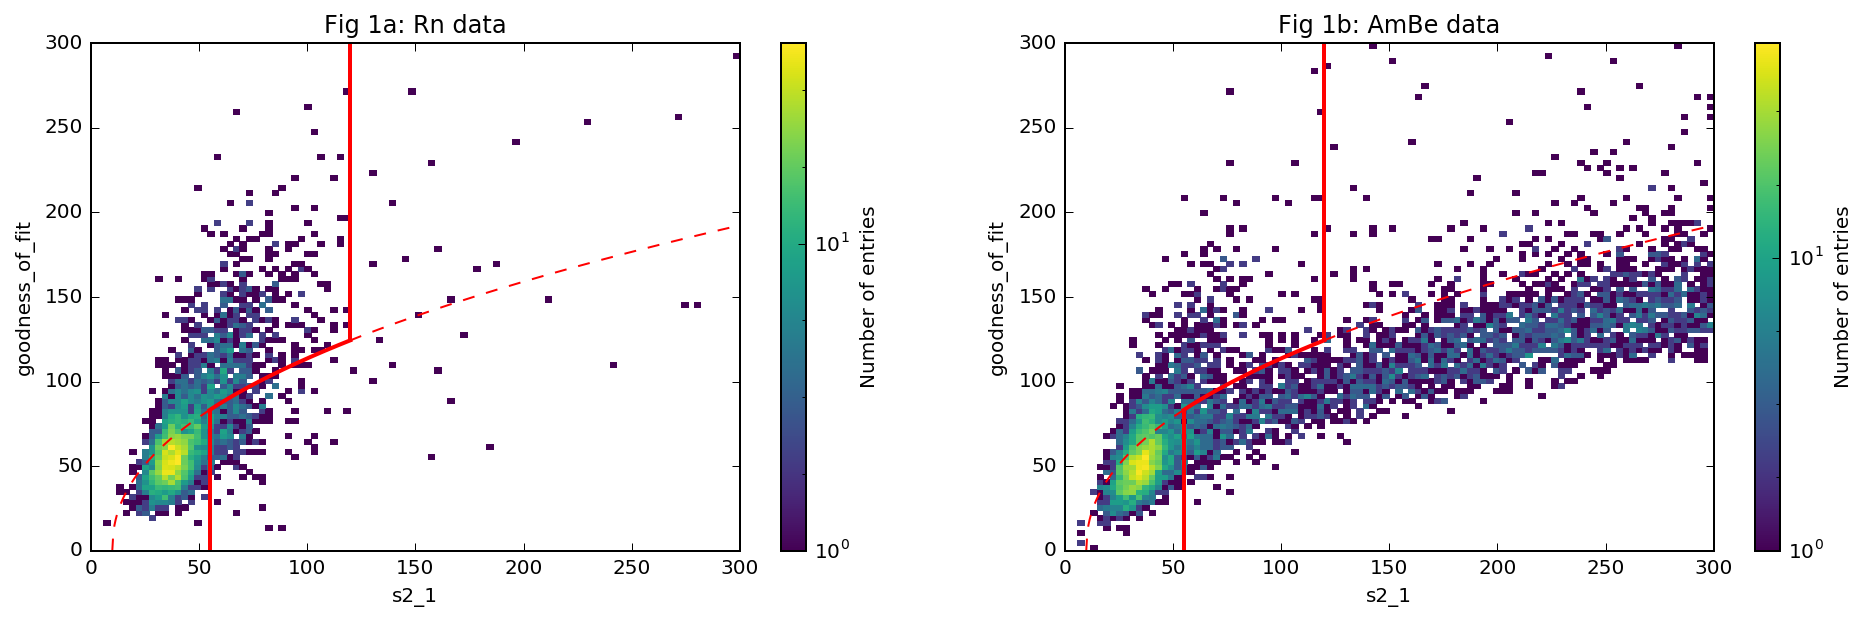

In [264]:
#########################Here we define the cut##################
plt.rcParams['figure.figsize'] = (16, 10)
fig = plt.figure()

def plotsups():
    x = np.linspace(55,120,141)
    y = np.linspace(0,300,601)
    plt.plot(x, 15 * (x -10) **0.45, 'r-', lw = 2.0)
    plt.axvline(120, ymin = 0.415, color = 'r', ls = '-', lw = 2.0)
    plt.axvline(55, ymax = 0.275, color = 'r', ls = '-', lw = 2.0)
    plt.plot(y, 15 * (y -10) **0.45, 'r--')
#####################################################################
df_ = df_rn
with plotting2d(221):
    mh = Histdd(getattr(df_, area), getattr(df_, gof),
                axis_names = ('s2_1', 'goodness_of_fit'),
                bins = (np.linspace(0,300,101), np.linspace(0,300,101)))
plt_config(title = 'Fig 1a: Rn data')
plotsups()

#####################################################################
df_ = df_nt
with plotting2d(222):
    mh = Histdd(getattr(df_, area), getattr(df_, gof),
                axis_names = ('s2_1', 'goodness_of_fit'),
                bins = (np.linspace(0,300,101), np.linspace(0,300,101)))
plt_config(title = 'Fig 1b: AmBe data')
plotsups()

plt.show()

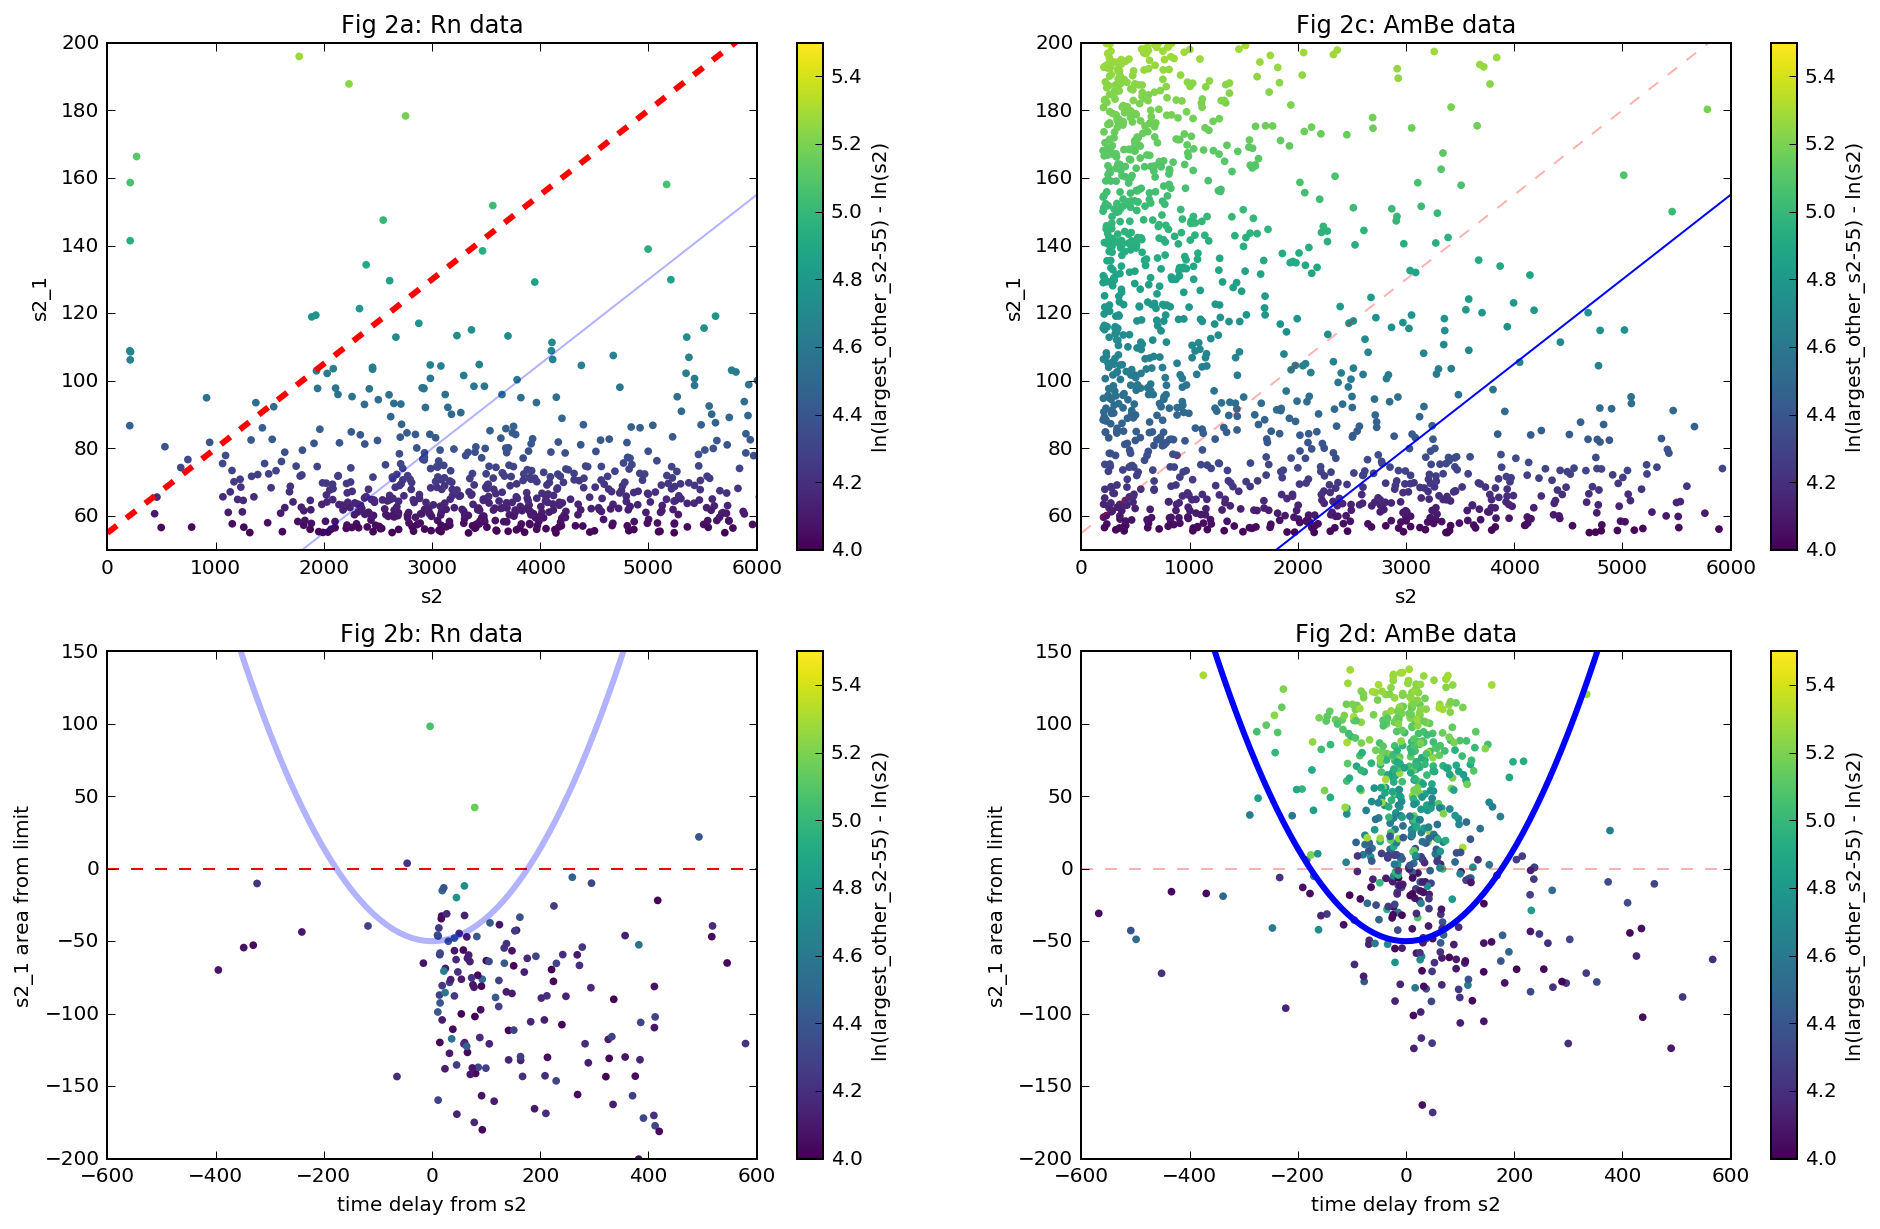

In [261]:
#########################Here we define the cut##################
plt.rcParams['figure.figsize'] = (16, 10)
fig = plt.figure()

x = np.linspace(0,6000,101)
y = np.linspace(-6e2, 6e2, 101) + 0j

ops = dict(s=15, edgecolor='none', cmap=plt.get_cmap('viridis'))
ops_2 = dict(xbounds = [0,6e3], ybounds = [50,200], colorbar = 'ln(largest_other_s2-55) - ln(s2)', xlabel = 's2', ylabel = 's2_1', sci = False)
ops_3 = dict(xbounds = [-6e2,6e2], ybounds = [-200,150], colorbar = 'ln(largest_other_s2-55) - ln(s2)', xlabel = 'time delay from s2', ylabel = 's2_1 area from limit', sci = False)
#####################################################################
ax = fig.add_subplot(221)
df_ = (sel_notse((sel_pu(df_rn))))
plt.scatter(getattr(df_, 's2'), getattr(df_, area), 
            c = np.log(getattr(df_, area) - 55 / getattr(df_, 's2')), vmin = 4, vmax = 5.5,  **ops)
plt_config(title = 'Fig 2a: Rn data', **ops_2)
plt.plot(x, 55 + x * 0.025, 'r--', lw = 3.0)
plt.plot(x, x * 0.025 + 5, 'b-', lw = 1.0, alpha = 0.3)

#####################################################################
ax = fig.add_subplot(223)
df_ = sel_notse(sel_notpu(df_rn))
plt.scatter(getattr(df_, dt2)/1e3,(getattr(df_, area) - 55) - getattr(df_, 's2') * 0.025,
            c = np.log(getattr(df_, area) - 55 / getattr(df_, 's2')), vmin = 4, vmax = 5.5, **ops)
plt_config(title = 'Fig 2b: Rn data', **ops_3)
plt.axhline(0, color = 'r', ls = '--', lw = 1.0)
plt.plot(y, (y/25)**2 - 50, 'b-', lw = 3.0, alpha = 0.3)

#####################################################################
ax = fig.add_subplot(222)
df_ = (sel_notse((sel_pu(df_nt))))
plt.scatter(getattr(df_, 's2'), getattr(df_, area),
            c = np.log(getattr(df_, area) - 55 / getattr(df_, 's2')), vmin = 4, vmax = 5.5, **ops)
plt_config(title = 'Fig 2c: AmBe data', **ops_2)
plt.plot(x, 55 + x * 0.025, 'r--', lw = 1.0, alpha = 0.3)
plt.plot(x, x * 0.025 + 5, 'b-', lw = 1.0)

#####################################################################
ax = fig.add_subplot(224)
df_ = sel_notse(sel_notpu(df_nt))
plt.scatter(getattr(df_, dt2)/1e3,(getattr(df_, area) - 55) - getattr(df_, 's2') * 0.025,
            c = np.log(getattr(df_, area) - 55 / getattr(df_, 's2')), vmin = 4, vmax = 5.5, **ops)
plt_config(title = 'Fig 2d: AmBe data', **ops_3)
plt.axhline(0, color = 'r', ls = '--', lw = 1.0, alpha = 0.3)
plt.plot(y, (y/25)**2 - 50, 'b-', lw = 3.0)

plt.show()

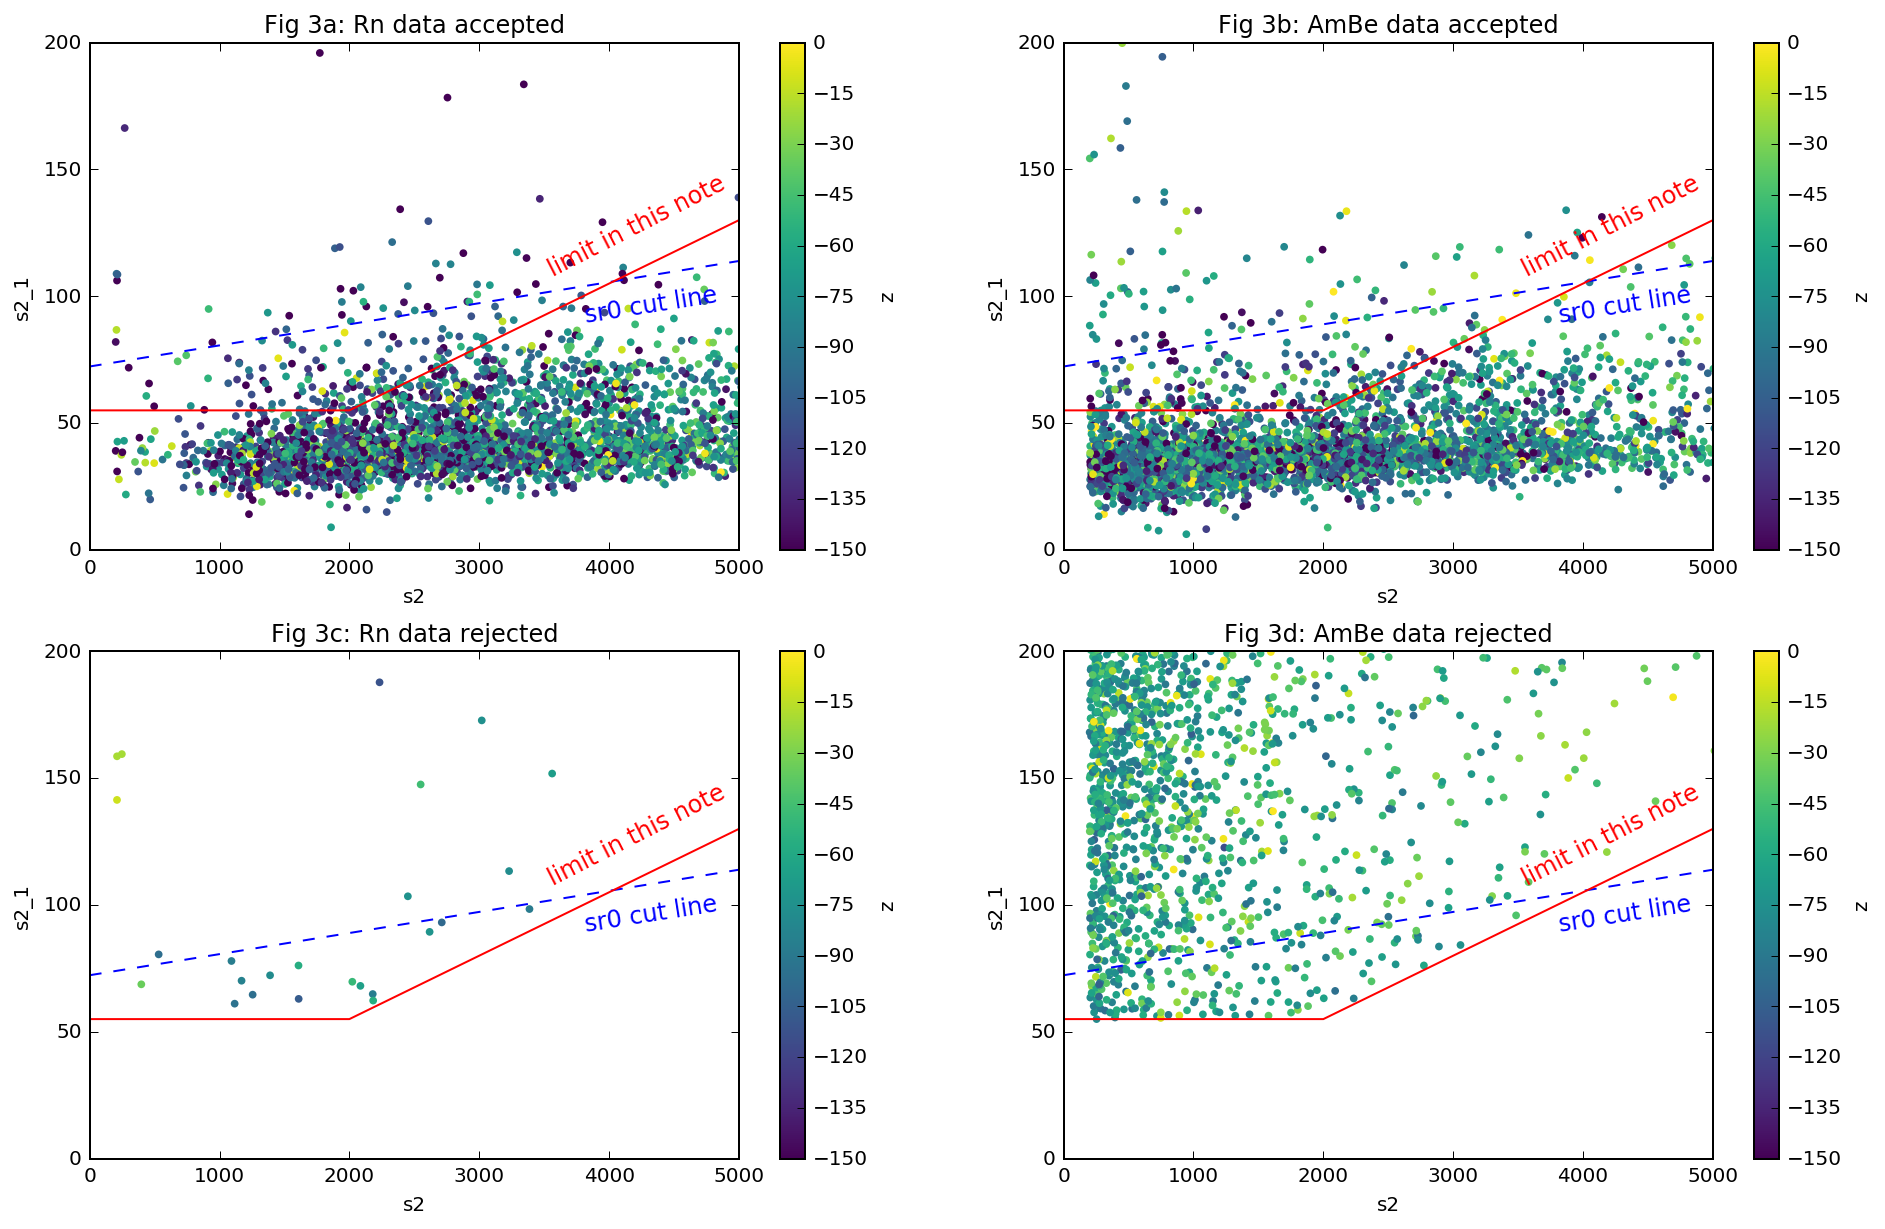

In [285]:
plt.rcParams['figure.figsize'] = (16, 10)
fig = plt.figure()

def plotsups():
    x = np.linspace(0,8e3,101)
    plt.plot(x, ses2_size_cut_ori(x), 'b--')
    plt.plot(x, np.clip(5 + x * 0.025, 55, 1e5), 'r-')
    plt.text(3800, 98, 'sr0 cut line', color = 'b', size = 12.0, rotation=9)
    plt.text(3500, 142, 'limit in this note', color = 'r', size = 12.0, rotation=27)

    
ops = dict(s=15, edgecolor='none', cmap=plt.get_cmap('viridis'))
ops_2 = dict(xlabel = 's2', ylabel = 's2_1', xbounds = [0,5e3], ybounds = [0,200], colorbar = 'z', sci = False)
#####################################################################
ax = fig.add_subplot(221)
df_ = sel_ss(df_rn)
plt.scatter(getattr(df_, 's2'), getattr(df_, area), c = getattr(df_, 's2_1_z'), vmin = -150, vmax = 0, **ops)
plt_config(title = 'Fig 3a: Rn data accepted', **ops_2)
plotsups()

#####################################################################
ax = fig.add_subplot(222)
df_ = sel_ss(df_nt)
plt.scatter(getattr(df_, 's2'), getattr(df_, area), c = getattr(df_, 's2_1_z'), vmin = -150, vmax = 0, **ops)
plt_config(title = 'Fig 3b: AmBe data accepted', **ops_2)
plotsups()

#####################################################################
ax = fig.add_subplot(223)
df_ = sel_ms(df_rn)
plt.scatter(getattr(df_, 's2'), getattr(df_, area), c = getattr(df_, 's2_1_z'), vmin = -150, vmax = 0, **ops)
plt_config(title = 'Fig 3c: Rn data rejected', **ops_2)
plotsups()

#####################################################################
ax = fig.add_subplot(224)
df_ = sel_ms(df_nt)
plt.scatter(getattr(df_, 's2'), getattr(df_, area), c = getattr(df_, 's2_1_z'), vmin = -150, vmax = 0, **ops)
plt_config(title = 'Fig 3d: AmBe data rejected', **ops_2)
plotsups()

plt.show()